In [1]:
import numpy as np
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
from galpy.df import streamdf,streamgapdf  
from galpy.util import bovy_coords, bovy_conversion
import pal5_util
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
import SCFbar_util
from astropy import units
import astropy.units as u
import streamspraydf
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap
from galpy.potential import SCFPotential


ro=8.
vo=220.

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]


Populating the interactive namespace from numpy and matplotlib


## compare particle spray vs streamdf in MWPotential2014

In [2]:
p5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])

#convert to galpy units
pal5=Orbit(p5._orb.vxvv)

#mass of Pal 5 from Dehnen https://arxiv.org/pdf/astro-ph/0401422.pdf
spdf= streamspraydf.streamspraydf(5200.*units.Msun,progenitor=pal5,pot=MWPotential2014,tdisrupt=5.*units.Gyr)
spdft= streamspraydf.streamspraydf(5200.*units.Msun,progenitor=pal5,pot=MWPotential2014,leading=False,tdisrupt=5.*units.Gyr)

N=100

#Rt,vRt,vTt,zt,vzt,phit
RvRl,pdtl= spdf.sample(n=N,returndt=True,integrate=True)
RvRt,pdtt= spdft.sample(n=N,returndt=True,integrate=True)

In [3]:
#setup Pal 5 smooth stream from streamdf
sdf_trailing= pal5_util.setup_pal5model(pot=MWPotential2014)
sdf_leading= pal5_util.setup_pal5model(pot=MWPotential2014,leading=True)
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)

In [4]:
#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

lt_p=numpy.empty(N)
bt_p=numpy.empty(N)
dttp=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)
dtlp=numpy.empty(N)

for ii in range(N):
    lt_p[ii]=galcencyl_to_lbd(RvRt[0][ii],RvRt[5][ii],RvRt[3][ii])[0]
    bt_p[ii]=galcencyl_to_lbd(RvRt[0][ii],RvRt[5][ii],RvRt[3][ii])[1]
    dttp[ii]=numpy.digitize(pdtt[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    
    ll_p[ii]=galcencyl_to_lbd(RvRl[0][ii],RvRl[5][ii],RvRl[3][ii])[0]
    bl_p[ii]=galcencyl_to_lbd(RvRl[0][ii],RvRl[5][ii],RvRl[3][ii])[1]
    dtlp[ii]=numpy.digitize(pdtl[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    
    dtt_s[ii]=numpy.digitize(dtt[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[ii]=galcencyl_to_lbd(Rt[ii],phit[ii],zt[ii])[0]
    bt_unp[ii]=galcencyl_to_lbd(Rt[ii],phit[ii],zt[ii])[1]
    
    dtl_s[ii]=numpy.digitize(dtl[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    ll_unp[ii]=galcencyl_to_lbd(Rl[ii],phil[ii],zl[ii])[0]
    bl_unp[ii]=galcencyl_to_lbd(Rl[ii],phil[ii],zl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 

radect=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
radecl=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)


[0. 1. 2. 3. 4. 5.]


In [5]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



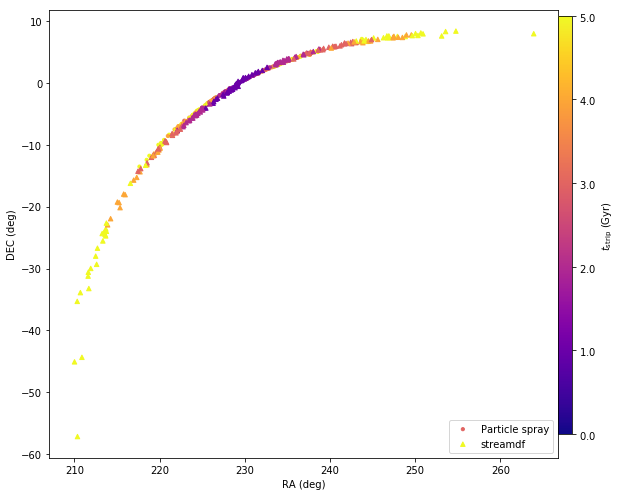

In [6]:
#plot stream 

plt.figure(figsize=(8,7))
plt.scatter(radecpt[:,0],radecpt[:,1],s=10,color=color_from_colormap(dttp,cmap,0.,5.),label='Particle spray')
plt.scatter(radecpl[:,0],radecpl[:,1],s=10,color=color_from_colormap(dtlp,cmap,0.,5.))

plt.scatter(radect[:,0],radect[:,1],s=20,marker="^",color=color_from_colormap(dtt_s,cmap,0.,5.),label='streamdf')
plt.scatter(radecl[:,0],radecl[:,1],s=20,marker="^",color=color_from_colormap(dtl_s,cmap,0.,5.))
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(220.,290.)
#plt.ylim(-10.,10.)
plt.legend(loc="lower right")
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/smooth_Pal5_10_10Msun_patspeed35_ang27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()


## Setup SCFbar such that it starts growing at -x Gyr

In [7]:
class mySCFPotential(SCFPotential):
    def _R2deriv(self,R,z,phi=0.,t=0.):
        dR= 1e-8
        return (self._Rforce(R,z,phi,t) - self._Rforce(R+dR,z,phi,t))/dR
    
    def _z2deriv(self,R,z,phi=0.,t=0.):
        dz = 1e-8
        return (self._zforce(R,z,phi,t) - self._zforce(R,z+dz,phi,t))/dz
    
    def _Rzderiv(self,R,z,phi=0.,t=0.):
        dR = 1e-8
        return (self._zforce(R,z,phi,t) - self._zforce(R+dR,z,phi,t))/dR

def Particle_Spray_MWPotentialSCFbar(mbar,Acos,Asin,rs=1.,normalize=False,pat_speed=40.,fin_phi_deg=27.,t_stream_age=-5.,t_on=-2.,tgrow=2):
    
    '''
    t_stream_age : age of the stream/max stripping time
    t_on: time in Gyr in the past at which the bar acquired full strength
    tgrow: no of bar periods it took the bar to grow to full strength starting at tform
            
    '''
    
    #setup the full strength bar and axisymmetric "bar"
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    
    fin_phi= np.radians(fin_phi_deg)
        
    init_phi= fin_phi - omegaP*np.abs(t_stream_age)/bovy_conversion.time_in_Gyr(vo,ro)
    
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=mySCFPotential(amp=mrat,Acos=Acos,Asin=Asin,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=mySCFPotential(amp=mrat,Acos=np.atleast_3d(Acos[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=init_phi)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    
    #setup Dehnen smooth growth wrapper for the bar
    #convert to galpy units
    #t_stream_age=np.abs(t_stream_age)/bovy_conversion.time_in_Gyr(vo,ro)
    
    Tbar=2.*np.pi/omegaP #bar period in galpy units.
    t_on=t_on/bovy_conversion.time_in_Gyr(vo,ro)
    tsteady=tgrow*Tbar
    tform = t_on - tsteady #- because past is negative
    print (tform)
       
    MWbar_grow=DehnenWrap(amp=1.,pot=MWP2014SCFbar,tform=tform,tsteady=tsteady)  
    MWaxibar_destroy=DehnenWrap(amp=-1.,pot=MWP2014SCFnobar,tform=tform,tsteady=tsteady) 

    growbarpot=[MWbar_grow,MWP2014SCFnobar,MWaxibar_destroy]

    turn_physical_off(growbarpot)
    
    return (growbarpot,MWP2014SCFnobar)

In [8]:
#plot density and potential contours of axi and non axi bar

Mbar=10**10.
pat_speed=40.
ang=27.

Ac,As=SCFbar_util.compute_Acos_Asin()
barpot,nobarpot=Particle_Spray_MWPotentialSCFbar(mbar=Mbar,Acos=Ac,Asin=As,t_on=-2.,t_stream_age=-5.)

SCFbar,SCFnobar=SCFbar_util.MWPotentialSCFbar(mbar=Mbar,Acos=Ac,Asin=As,pat_speed=40.,fin_phi_deg=27.,t_stream_age=5.,t_on=2.,tgrow=2)


-64.88854887532585


In [9]:
#compute rtide for some random points and time

from galpy.potential import rtide, evaluateRforces
print (evaluateRforces(barpot,2,3,1,5))
rtides= rtide(barpot,1,6,phi=5.,
                          t=-2,M=5200.*units.Msun,use_physical=False)

print (rtides)

-0.10814082987317292
0.011407595444997557


/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/TwoPowerSphericalPotential.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: invalid value encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:258: Runt

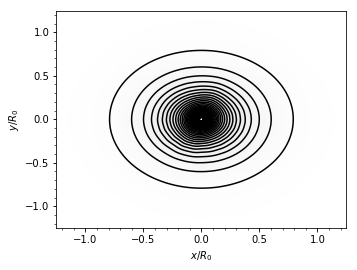

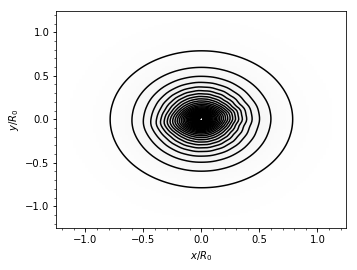

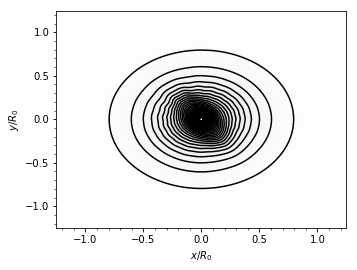

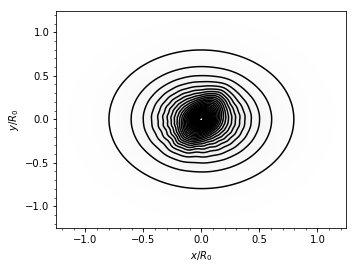

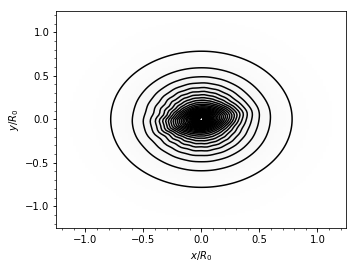

In [10]:
#plot the bar's density contours 
plotDensities(barpot,t=-2.2*units.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)
plotDensities(barpot,t=-2.15*units.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)
plotDensities(barpot,t=-2.10*units.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)
plotDensities(barpot,t=-2.05*units.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)
plotDensities(barpot,t=1.*units.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)

#### check how well the particle spray method matches streamdf in the presence of a bar. We have to be careful, since in the particle spray method the effect of the bar on the progenitor is included. In order to not include that effect, let's follow the following steps:

#### 1. Initialize particle spray stream with axially symmetric barred potential
#### 2. sample points from the particle spray method at the time of stripping and integrate them to present time in barred potential
#### 3. Use the previously developed back and forward integration code to get a sample of stars in the streamdf case 

In [12]:
p5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])

#convert to galpy units
pal5=Orbit(p5._orb.vxvv)

#mass of Pal 5 from Dehnen https://arxiv.org/pdf/astro-ph/0401422.pdf
spdf= streamspraydf.streamspraydf(5200.*units.Msun,progenitor=pal5,pot=barpot,tdisrupt=5.*units.Gyr)
spdft= streamspraydf.streamspraydf(5200.*units.Msun,progenitor=pal5,pot=barpot,leading=False,tdisrupt=5.*units.Gyr)

N=100

#Rt,vRt,vTt,zt,vzt,phit
RvRl,pdtl= spdf.sample(n=N,returndt=True,integrate=False)
RvRt,pdtt= spdft.sample(n=N,returndt=True,integrate=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
lt_p=numpy.empty(N)
bt_p=numpy.empty(N)
dttp=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)
dtlp=numpy.empty(N)

for ii in range(N):
    lt_p[ii]=galcencyl_to_lbd(RvRt[0][ii],RvRt[5][ii],RvRt[3][ii])[0]
    bt_p[ii]=galcencyl_to_lbd(RvRt[0][ii],RvRt[5][ii],RvRt[3][ii])[1]
    dttp[ii]=numpy.digitize(pdtt[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    
    ll_p[ii]=galcencyl_to_lbd(RvRl[0][ii],RvRl[5][ii],RvRl[3][ii])[0]
    bl_p[ii]=galcencyl_to_lbd(RvRl[0][ii],RvRl[5][ii],RvRl[3][ii])[1]
    dtlp[ii]=numpy.digitize(pdtl[ii]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 


In [ ]:
plt.figure(figsize=(8,7))
plt.scatter(radecpt[:,0],radecpt[:,1],s=10,color=color_from_colormap(dttp,cmap,0.,5.),label='Particle spray')
plt.scatter(radecpl[:,0],radecpl[:,1],s=10,color=color_from_colormap(dtlp,cmap,0.,5.))

plt.scatter(radect[:,0],radect[:,1],s=20,marker="^",color=color_from_colormap(dtt_s,cmap,0.,5.),label='streamdf')
plt.scatter(radecl[:,0],radecl[:,1],s=20,marker="^",color=color_from_colormap(dtl_s,cmap,0.,5.))
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(220.,290.)
#plt.ylim(-10.,10.)
plt.legend(loc="lower right")
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/smooth_Pal5_10_10Msun_patspeed35_ang27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
